# Fraud Notebook

In [30]:
# from numpy import loadtxt
import pandas as pd
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns 

In [234]:
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
import time
import lightgbm as lgb

In [6]:
pd.set_option('display.max_columns',50)

In [105]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

#     for name in summary['Name'].value_counts().index:
#         summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.   
    libraries: 
        numpy as np 
        pandas as pd
    Input: 
        df (pd.Dataframe):
    Output:
        df (pd.Dataframe):
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def calc_outliers(df_num): 
    '''
    Provides outlier information given a series or np array. Outliers are identified
    as being 3 standard deviations away from the mean.
    
    Input:
        df_num (pd.Series | np.array)
    Output:
        None, prints counts and percentage of outliers'''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [3]:
data_folder = 'data/'
train_identity = pd.read_csv(data_folder + 'train_identity.csv')

In [4]:
len(train_identity.columns)

41

In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_identity.shape

(144233, 41)

In [5]:
train_transaction = pd.read_csv(data_folder + 'train_transaction.csv')

In [176]:
test_transaction = pd.read_csv(data_folder + 'test_transaction.csv')

In [187]:
test_identity = pd.read_csv(data_folder + 'test_identity.csv')

In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,...,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_transaction.rename(columns={'card6':'card_type'}, inplace=True)


In [10]:
train_transaction.rename(columns={'card4':'card_company'}, inplace=True)

In [21]:
# train_transaction = reduce_mem_usage(train_transaction)

In [20]:
train_transaction.to_pickle('data/train_transaction.pkl')

In [22]:
df_summary(train_transaction)

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,TransactionID,int32,0,590540,2987000,2987001,2987002
1,isFraud,int8,0,2,0,0,0
2,TransactionDT,int32,0,573349,86400,86401,86469
3,TransactionAmt,float16,0,8195,68.5,29,59
4,ProductCD,category,0,5,W,W,W
5,card1,int16,0,13553,13926,2755,4663
6,card2,float16,8933,500,NaN,404,490
7,card3,float16,1565,114,150,150,150
8,card4,category,1577,4,discover,mastercard,visa
9,card5,float16,4259,119,142,102,166


In [52]:
train_transaction.TransactionAmt = train_transaction.TransactionAmt.astype(float)

In [53]:
train_transaction.groupby('isFraud').sum().TransactionAmt

isFraud
0    7.665521e+07
1    3.083836e+06
Name: TransactionAmt, dtype: float64

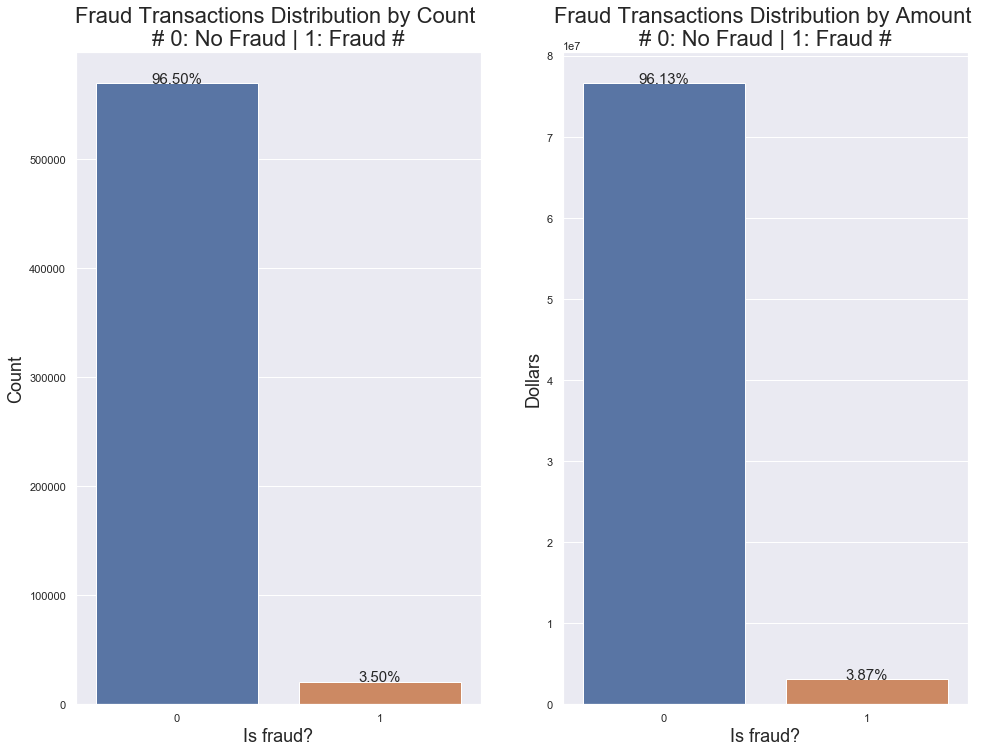

In [64]:
fig,ax = plt.subplots(figsize=(16,12))
sns.set()
total=train_transaction.shape[0]
plt.subplot(121)

g = sns.countplot(x='isFraud', data=train_transaction, )
g.set_title("Fraud Transactions Distribution by Count \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

plt.subplot(122)

amt_per_label = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
amt_per_label = amt_per_label.reset_index()
total_amt = train_transaction.TransactionAmt.sum()
g2 = sns.barplot(x='isFraud', y = 'TransactionAmt', data=amt_per_label)
g2.set_title("Fraud Transactions Distribution by Amount \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g2.set_xlabel("Is fraud?", fontsize=18)
g2.set_ylabel('Dollars', fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=15) 


In [83]:

print("Transaction Amounts Quantiles:")
non_fraud_transaction_amts = train_transaction['TransactionAmt']\
    .quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99])
fraud_trans_amts = train_transaction[train_transaction.isFraud == True]['TransactionAmt']\
      .quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99])
joined_trans_amts = pd.concat([non_fraud_transaction_amts,fraud_trans_amts],axis = 1)
joined_trans_amts.columns = ['Legitimate Transactions','Fraudulent Transactions']
joined_trans_amts

Transaction Amounts Quantiles:


,Legitimate Transactions,Fraudulent Transactions
0.010,9.242188,6.739453
0.025,14.500000,9.510156
0.100,25.953125,18.937500
0.250,43.312500,35.031250
0.500,68.750000,75.000000
0.750,125.000000,161.000000
0.900,275.250000,335.000000
0.975,648.262500,884.000000
0.990,1104.000000,994.000000


Text(0.5, 0, 'Log(TransactionAmt)')

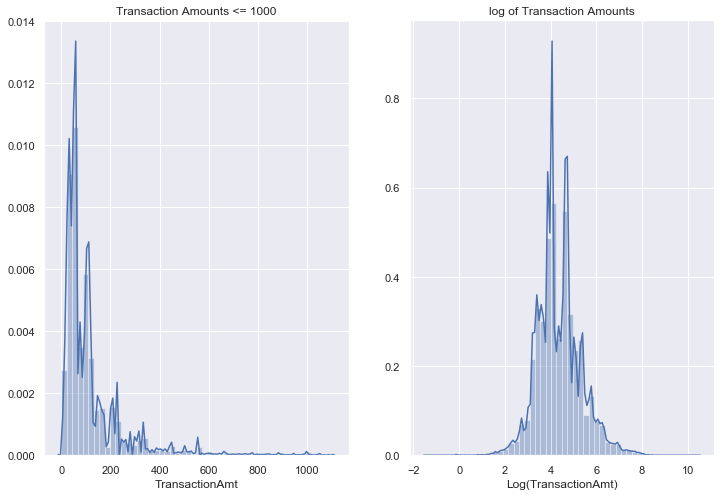

In [100]:
fig,ax = plt.subplots(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Transaction Amounts <= 1000')
sns.distplot(train_transaction[train_transaction.TransactionAmt <= 1100 ].TransactionAmt)
plt.subplot(1,2,2)
plt.title('log of Transaction Amounts')

sns.distplot(np.log(train_transaction.TransactionAmt))
plt.xlabel('Log(TransactionAmt)')

In [104]:
calc_outliers(train_transaction.TransactionAmt)

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


In [117]:
ct = pd.crosstab(train_transaction.ProductCD,train_transaction.isFraud,normalize='index') * 100
ct.reset_index()
ct.rename(columns={0:'NotFraud', 1:'Fraud'}, inplace=True)
# Splits each productCD into proportions of fraud and not fraud. Normalize by index
# means each row index adds to 100%

In [165]:
def count_plot_with_perc(df, column_name):
    '''
    Given a dataframe and a string containing column name, outputs a seaborn
    graph with percentages of categorical variables above each bar count
    
    Input: 
        df (pd.DataFrame)
        column_name (string)
    Output:
        None, displays count graph
    '''
    total = df.shape[0]
    g= sns.countplot(x=column_name,
                 data=df,
                 order=df[column_name].value_counts().index)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,#X position = left of rectangle + 1/2 of width = center
                height + 1000, #Y position = Height in 'data coordinates' = units on the y axis
                '{:1.2f}%'.format(height/total*100), # min 1 char before, 2 chars after, % sign
                ha="center", # Horizontal align center
               fontsize=14)
    g.set_title('Count Distribution of '+ column_name,fontsize = 19)
    g.set_ylabel('Count',fontsize = 17)
    g.set_xlabel(column_name,fontsize = 17)


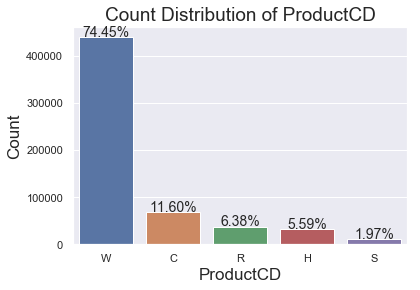

In [158]:
count_plot_with_perc(train_transaction,'ProductCD')

In [166]:
ct

isFraud,NotFraud,Fraud
ProductCD,,
C,88.312731,11.687269
H,95.233769,4.766231
R,96.217406,3.782594
S,94.100447,5.899553
W,97.960061,2.039939


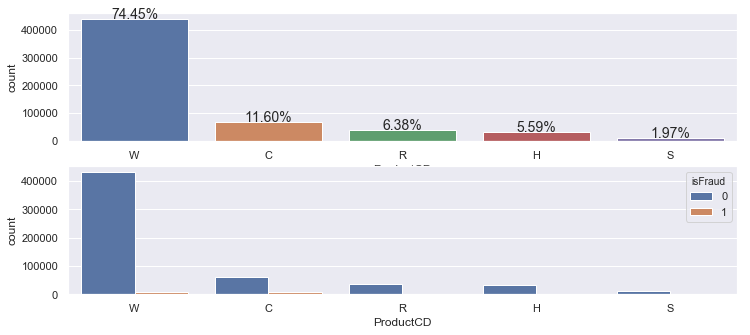

In [171]:
plt.subplots(figsize=(12,8))
plt.subplot(3,1,1)
g= sns.countplot(x='ProductCD',
                 data=train_transaction,
                 order=train_transaction.ProductCD.value_counts().index)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2., # X position is left of rectangle + half of width = center
            height + 1000, # Y position = Height in 'data coordinates' - units on the y axis
            '{:1.2f}%'.format(height/total*100), # min 1 char before, 2 chars after, adds % sign
            ha="center", # Horizontal align center
           fontsize=14)
plt.subplot(3,1,2)
g= sns.countplot(x='ProductCD',
                 data=train_transaction,
                 order=train_transaction.ProductCD.value_counts().index,
                 hue = 'isFraud')
# for p in g.patches:
#     height = p.get_height()
#     print(int(p.get_x()))
#     g.text(p.get_x()+p.get_width()/2., # X position is left of rectangle + half of width = center
#             height + 1000, # Y position = Height in 'data coordinates' - units on the y axis
#             '{:1.2f}%'.format(height/total*100), # min 1 char before, 2 chars after, adds % sign
#             ha="center", # Horizontal align center
#            fontsize=14)

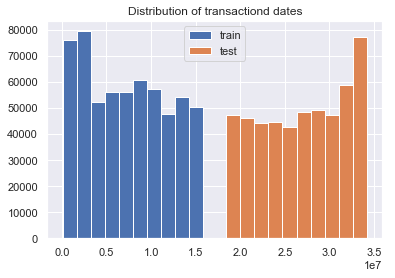

In [178]:
plt.hist(train_transaction['TransactionDT'], label='train');
plt.hist(test_transaction['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

In [14]:
train_transaction.loc[:50,'V1':].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,6.0,6.0,6.000000,6.000000,6.0,6.000000,6.000000,6.0,6.0,6.0
mean,1.0,1.050000,1.050000,1.000000,1.050000,1.050000,1.050000,1.050000,1.050000,0.400000,...,0.0,0.0,24.166667,4.166667,0.0,24.166667,4.166667,0.0,0.0,0.0
std,0.0,0.223607,0.223607,0.324443,0.394034,0.223607,0.223607,0.223607,0.223607,0.598243,...,0.0,0.0,59.196002,10.206207,0.0,59.196002,10.206207,0.0,0.0,0.0
min,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
25%,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
50%,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
75%,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
max,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.0,0.0,145.000000,25.000000,0.0,145.000000,25.000000,0.0,0.0,0.0


In [15]:
train_transaction.shape[0]

590540

In [16]:
sub=pd.read_csv(data_folder + 'sample_submission.csv')

In [18]:
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

# C1 is a Magic Var

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score
import graphviz

In [21]:
y= train_transaction.isFraud.values
X= train_transaction.loc[:,['C1','C3']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.5959281274988184


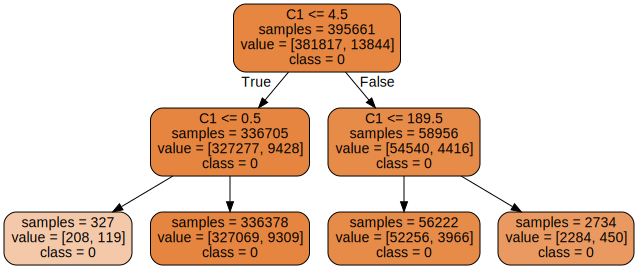

In [23]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = X.columns, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)

In [30]:
model = XGBClassifier(n_estimators=600, random_state=4, learning_rate=.1, verbose=True,)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1, verbose=True)

In [31]:
y_pred = model.predict(X_test)
roc_auc_score(y_test,y_pred)

0.5

In [ ]:
test_transaction.columns

In [249]:
train = train_transaction.merge(train_identity,on='TransactionID',how='left')
test = test_transaction.merge(test_identity,on='TransactionID',how='left')

In [250]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test
many_null_cols = [col for col in train.columns if train[col].isnull().sum() /
                  train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() /
                       test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns
                      if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns
                           if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test +
                        big_top_value_cols + big_top_value_cols_test +
                        one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)



82

In [251]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [252]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [253]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )



In [254]:
from numba import jit
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True
def train_model_classification(X, X_test, y,
                               params, folds, model_type='lgb',
                               eval_metric='auc', columns=None,
                               plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200,
                               n_estimators=50000, splits=None, n_folds=3,
                               averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary,
    feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators,
                              evals=watchlist, early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid,
                                                     feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators,
                                       eval_metric=metrics_dict[eval_metric]\
                                       ['catboost_metric_name'],
                                       **params,
                                       loss_function='Logloss')
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid),
                      cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid,
                                                                                y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid,
                                                                                y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature",
                                       "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature",
                        data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

In [255]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

Fold 1 started at Fri Sep 27 12:30:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.992936	training's auc: 0.992936	valid_1's auc: 0.91768	valid_1's auc: 0.91768
Early stopping, best iteration is:
[518]	training's auc: 0.993307	training's auc: 0.993307	valid_1's auc: 0.917733	valid_1's auc: 0.917733
Fold 2 started at Fri Sep 27 12:39:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.993429	training's auc: 0.993429	valid_1's auc: 0.93087	valid_1's auc: 0.93087
Early stopping, best iteration is:
[624]	training's auc: 0.995589	training's auc: 0.995589	valid_1's auc: 0.931468	valid_1's auc: 0.931468
Fold 3 started at Fri Sep 27 12:48:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.993475	training's auc: 0.993475	valid_1's auc: 0.927482	valid_1's auc: 0.927482
Early stopping, best iteration is:
[333]	training's auc: 0.987887	training's auc: 0.987887	valid

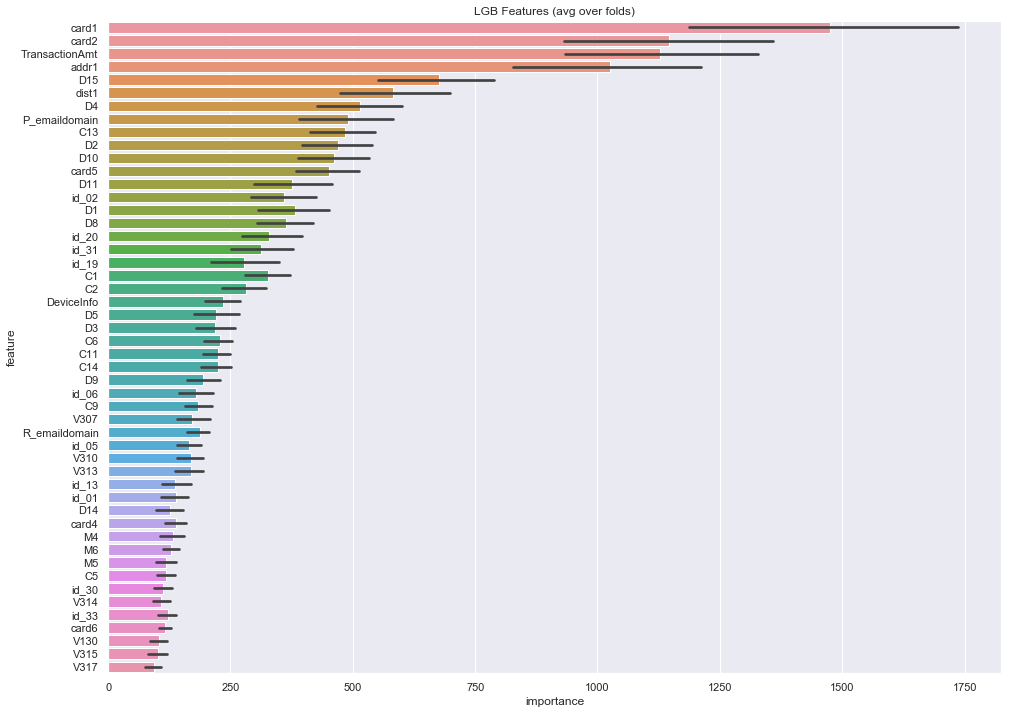

In [256]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
# Example call and parameter pass
result_dict_lgb = train_model_classification(X=X,
                                             X_test=X_test,
                                             y=y,
                                             params=params,
                                             folds=folds,
                                             model_type='lgb',
                                             eval_metric='auc',
                                             plot_feature_importance=True,                                             
                                            verbose=500,
                                             early_stopping_rounds=200,
                                             n_estimators=5000,
                                             averaging='usual',
                                             n_jobs=-1)


In [239]:
sub = pd.read_csv(data_folder + 'sample_submission.csv')


In [264]:
sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [263]:
test.head()

,TransactionDT,TransactionID
0,18403224,3663549
1,18403263,3663550
2,18403310,3663551
3,18403310,3663552
4,18403317,3663553


In [258]:
test.shape

(506691, 2)

In [267]:
result_dict_lgb['prediction']

array([[0.00142757],
       [0.00102329],
       [0.00206417],
       ...,
       [0.00680928],
       [0.00905398],
       [0.00624619]])

In [278]:
result_dict_lgb

{'oof': array([[0.0500452 ],
        [0.01991825],
        [0.00874317],
        ...,
        [0.00328889],
        [0.03969774],
        [0.00149771]]), 'prediction': array([[0.00142757],
        [0.00102329],
        [0.00206417],
        ...,
        [0.00680928],
        [0.00905398],
        [0.00624619]]), 'scores': [0.9177332625484192,
  0.9314677525409957,
  0.9280697931510401,
  0.9473720111876327,
  0.9241716835807536], 'feature_importance':             feature  importance  fold
 0    TransactionAmt      1197.0     1
 1         ProductCD        50.4     1
 2             card1      1560.4     1
 3             card2      1197.4     1
 4             card3        98.4     1
 5             card4       143.0     1
 6             card5       480.2     1
 7             card6       108.2     1
 8             addr1      1057.8     1
 9             addr2         7.2     1
 10            dist1       624.8     1
 11    P_emaildomain       531.6     1
 12    R_emaildomain       194.8     1

In [261]:
sub.shape

(506691, 2)

In [268]:
sub['isFraud'] = result_dict_lgb['prediction']

In [281]:
sub.to_csv('submissions/submissions_v1.csv',index=False)

In [280]:
pd.read_csv('submissions_v1.csv')

,TransactionID,isFraud
0,3663549,0.001428
1,3663550,0.001023
2,3663551,0.002064
3,3663552,0.001650
4,3663553,0.001879
5,3663554,0.003289
6,3663555,0.016282
7,3663556,0.016180
8,3663557,0.000175
9,3663558,0.004277


In [248]:
sub['isFraud'].shape

(506691,)